# Rainier DEM Example

Since we are in Seattle, let’s use some DEMs of our friendly, neighborhood stratovolcano, Mount Rainier (AKA Tacoma or Tahoma). Can we calculate long-term and recent glacier elevation/volume change?

In [1]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

from pygeotools.lib import iolib, warplib, geolib, timelib, malib

### DEM sources:

- 1-arcsec (30-m) USGS National Elevation Dataset derived from digitized contour maps with 1970 source date (I merged several tiles and clipped to a large extent around Rainier)
- 10-m airborne LiDAR data from 2007/2008 (original LiDAR was on 1-m grid, I subsampled for this exercise)
- 8-m DEM derived from WorldView Stereo imagery acquired on August 8, 2015

|   |   |   |
|:-:|:-:|:-:|
|<img src="19700901_ned1_2003_adj_warp_fig.png" alt="1970 DEM" style="width: 341px;"/> | <img src="20080901_rainierlidar_10m-adj_fig.png" alt="2008 DEM" style="width: 341px;"/> | <img src="20150818_rainier_summer-tile-0_fig.png" alt="2015 DEM" style="width: 341px;"/> |

These may look similar at this scale, but there are subtle differences in the projeciton, extent, and resolution. So how can we compute elevation change for the same locations over time?

### Enter pygeotools warplib

As you might have guessed, GDAL provides all of the machinery needed to solve this problem. From the command line, one could preprocess all input datasets to a common projection, extent, and resolution using gdalwarp. But what if you want to do this in a Python script, or do on-the-fly analysis, without the unnecessary, time-consuming steps to read/write warped files from/to disk?

The pygeotools repository contains a number of tools built on the GDAL Python API. Several options make raster warping operations like this very easy, especially for an arbitrary number of input rasters. The warptool.py script offers a command-line interface (see usage), while the lib/warplib.py library contains the underlying functions. For this tutorial, we will use the memwarp functions in lib/warplib.py to prepare warped in-memory versions of our input DEMs that we can difference to study elevation change over time. Then, if there’s time, we’ll use NumPy and a few other pygeotools tricks to pull out some estimates for glacier volume and mass change.

In [2]:
#Input DEM filenames
dem_1970_fn = '../data/rainier/19700901_ned1_2003_adj_warp.tif'
dem_2008_fn = '../data/rainier/20080901_rainierlidar_10m-adj.tif'
dem_2015_fn = '../data/rainier/20150818_rainier_summer-tile-0.tif'
dem_fn_list = [dem_1970_fn, dem_2008_fn, dem_2015_fn]

OK, time for some warpin’. We are going to use the memwarp_multi_fn function, which accepts a list of raster filenames and allows the user to specify a desired output extent, resolution, and projection for each output in-memory GDAL dataset. In this case, we will clip everything to a common intersection, use the minimum (best) resolution, and preserve the projection of our 2015 DEM (in this case, UTM 10N, EPSG:32610). See the warptool.py usage for the range of valid inputs for the extent, res, and t_srs options.

The following will return warped, in-memory GDAL dataset objects. The key parameters are extent, res, and t_srs (projection):

- In this case, we want to clip all DEMs to the same common extent (extent='intersection')
- Let’s use the minimum (highest) resolution from all input DEMs (res='min')
- And let’s use the projection of the 2015 Stereo DEMs, in this case, just specify the filename (t_srs=dem_2015_fn)

Note: could also resample all inputs to a lower resolution for testing (e.g., use keyword argument res=128)

In [3]:
ds_list = warplib.memwarp_multi_fn(dem_fn_list, extent='intersection', res='min', t_srs=dem_2015_fn)


Warping all inputs to the following:
Resolution: 8.0
Extent: [583464.253406, 5179709.0989, 608272.253406, 5202549.0989]
Projection: '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 3: ../data/rainier/19700901_ned1_2003_adj_warp.tif
nl: 2855 ns: 3101 res: 8.000
2 of 3: ../data/rainier/20080901_rainierlidar_10m-adj.tif
nl: 2855 ns: 3101 res: 8.000
3 of 3: ../data/rainier/20150818_rainier_summer-tile-0.tif


That’s it. Note that warplib includes some shortcuts to avoid unnecessary warping if one of the input datasets already meets the output criteria.

Now we have a list of warped, consistent GDAL datsets for analysis. Let’s use the iolib.ds_getma function to load the datasets into NumPy masked arrays. Under the hood, this runs GDAL ReadAsArray and goes through a cascade of approaches to mask NoData values.

In [4]:
#Load datasets to NumPy masked arrays
dem_1970, dem_2008, dem_2015 = [iolib.ds_getma(i) for i in ds_list]

In [5]:
#Print some output info

print(dem_2015.shape)
print(dem_2015.dtype)

dem_2015

(2855, 3101)
float32


masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [1420.24169921875 1425.361083984375 1426.648681640625 ..., -- -- --]
 [1412.8729248046875 1419.9056396484375 1423.5897216796875 ..., -- -- --]
 [1409.49169921875 1414.83837890625 1417.3895263671875 ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [False False False ...,  True  True  True]
 [False False False ...,  True  True  True]
 [False False False ...,  True  True  True]],
       fill_value = 0.0)

OK, our array has 2855 rows, 3101 columns and the values are float32.

The print(dem_2015) command prints the first and last three rows (lines) and columns (samples) of the raster data, and then the first and last three rows/columns of the mask. Note that where the mask values are True, there was no valid raster data.

OK, we have some numbers, but I like colorful pictures, so let’s visualize this array of numbers as an image…

In [8]:
#Function to generate a 3-panel plot for input arrays
def plot3panel(dem_list, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None):
    fig, axa = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,6))
    alpha = 1.0
    for n, ax in enumerate(axa):
        #Gray background
        ax.set_facecolor('0.5')
        #Force aspect ratio to match images
        ax.set(adjustable='box-forced', aspect='equal')
        #Turn off axes labels/ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if titles is not None:
            ax.set_title(titles[n])
        #Plot background shaded relief map
        if overlay is not None:
            alpha = 0.7
            axa[n].imshow(overlay[n], cmap='gray', clim=(1,255)) 
    #Plot each array 
    im_list = [axa[i].imshow(dem_list[i], clim=clim, cmap=cmap, alpha=alpha) for i in range(len(dem_list))]
    fig.tight_layout()
    fig.colorbar(im_list[0], ax=axa.ravel().tolist(), label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)
    plt.show()

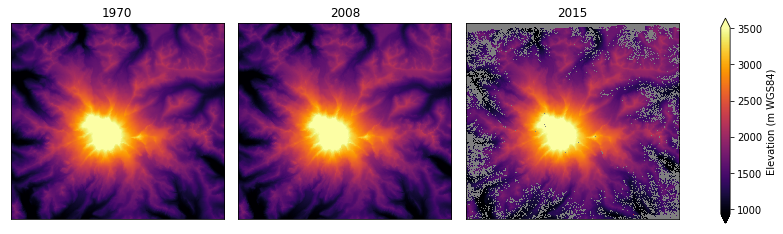

In [9]:
dem_list = [dem_1970, dem_2008, dem_2015]
titles = ['1970', '2008', '2015']
clim = malib.calcperc(dem_list[0], (2,98))
plot3panel(dem_list, clim, titles, 'inferno', 'Elevation (m WGS84)')

Hot! (that color ramp is called “inferno” btw)

We now have three arrays with identical extent/projection/resolution.

Computing elevation differences should now be really easy - just subtract one array from another.

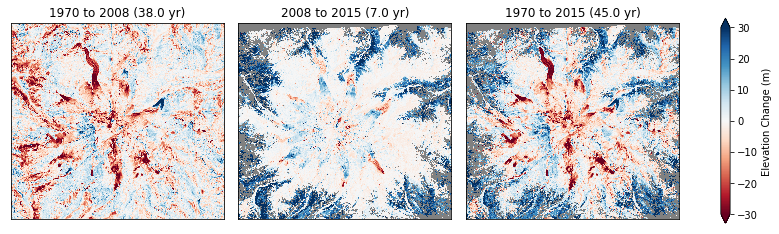

In [10]:
#Calculate elevation difference for each time period
#In this case, we will store the difference maps in a list for convenience
dh_list = [dem_2008 - dem_1970, dem_2015 - dem_2008, dem_2015 - dem_1970]

#Let's extract timestamps from filenames
t_list = np.array([timelib.fn_getdatetime(fn) for fn in dem_fn_list])
#Now let's compute total time between observations in decimal years
#Compute time differences, convert decimal years
dt_list = [timelib.timedelta2decyear(d) for d in np.diff(t_list)]
#Add the full 1970-2015 time difference
dt_list.append(dt_list[0]+dt_list[1])

#Now plot the elevation differences 
titles = ['1970 to 2008 (%0.1f yr)' % dt_list[0], '2008 to 2015 (%0.1f yr)' % dt_list[1], '1970 to 2015 (%0.1f yr)' % dt_list[2]]
plot3panel(dh_list, (-30, 30), titles, 'RdBu', 'Elevation Change (m)')

Interesting, the rainier glacier “starfish” starts to pop out (red/blue) among the surfaces that aren’t changing (white).

But, these are cumulative elevation change in meters for the three time periods. If we want to compare them directly, we should probably convert to some kind of average rate in meters per year. To do this, we will divide the total elevation change by the number of years between observations (which we calcluated above as dt_list).

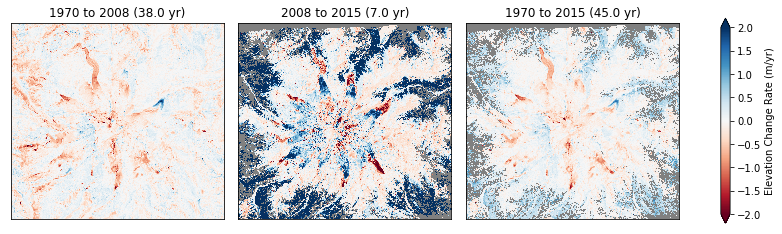

In [11]:
#Calculate annual rate of change
dhdt_list = np.ma.array(dh_list)/np.array(dt_list)[:,np.newaxis,np.newaxis]
plot3panel(dhdt_list, (-2, 2), titles, 'RdBu', 'Elevation Change Rate (m/yr)')

Hmmm, some strange positive signals over trees. Are they growing 3 m/yr? That would be exciting, but probably not. Looks like our 1970 and 2008 DEMs were “bare-ground” digital terrain models (DTMs), while the 2015 DEM was a digital surface model (DSM) that included vegetation.

Let’s clip our map to the glaciers using polygons from the [Randolph Glacier Inventory (RGI)](https://www.glims.org/RGI/). I use the [get_rgi.sh](https://github.com/dshean/demcoreg/blob/master/demcoreg/get_rgi.sh) script in the demcoreg repo to fetch, extract and prepare a global shapefile.

To things keep moving, I’ve already isolated the glacier polygons for Rainier from the global RGI. We’re going to first rasterize these polygons to match our warped datasets using the pygeotools geolib.shp2array function. Then we’re going to update the existing mask on each difference map, so that only glacier pixels remain unmasked.

Input shp srs: +proj=longlat +datum=WGS84 +no_defs 
Specified output srs: +proj=utm +zone=10 +datum=WGS84 +units=m +no_defs 


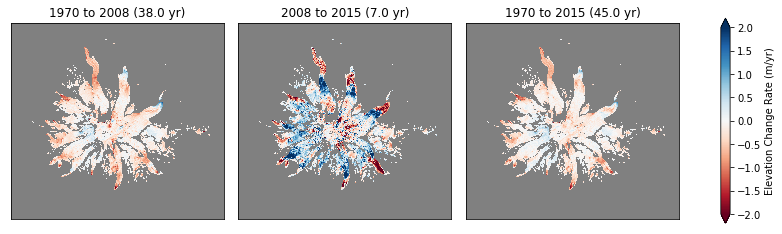

In [12]:
shp_fn = '../data/rainier/rgi60_glacierpoly_rainier.shp'
#Create binary mask from polygon shapefile to match our warped raster datasets
shp_mask = geolib.shp2array(shp_fn, ds_list[0])
#Now apply the mask to each array 
dhdt_list_shpclip = [np.ma.array(dhdt, mask=shp_mask) for dhdt in dhdt_list]
plot3panel(dhdt_list_shpclip, (-2, 2), titles, 'RdBu', 'Elevation Change Rate (m/yr)')

Now that’s one patriotic starfish. Seeing some big elevation change signals, but some context would be nice. Let’s generate some shaded relief basemaps using gdaldem API functionality

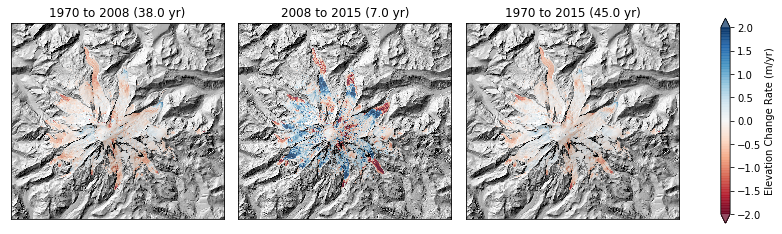

In [13]:
dem_1970_hs_ds = gdal.DEMProcessing('', ds_list[0], 'hillshade', format='MEM')
dem_1970_hs = iolib.ds_getma(dem_1970_hs_ds)
dem_2008_hs_ds = gdal.DEMProcessing('', ds_list[1], 'hillshade', format='MEM')
dem_2008_hs = iolib.ds_getma(dem_2008_hs_ds)
hs_list = [dem_1970_hs, dem_2008_hs, dem_1970_hs]

#Plot our clipped rates over shaded relief maps
plot3panel(dhdt_list_shpclip, (-2, 2), titles, 'RdBu', 'Elevation Change Rate (m/yr)', overlay=hs_list)

OK, great, so we have a sense of spatial distribution of elevation change.

Can we now estimate total glacier volume and mass change for the different periods?

In [14]:
#Extract x and y pixel resolution (m) from geotransform
gt = ds_list[0].GetGeoTransform()
px_res = (gt[1], -gt[5])
#Calculate pixel area in m^2
px_area = px_res[0]*px_res[0]
dhdt_list_shpclip_rs = np.ma.array(dhdt_list_shpclip).reshape(len(dhdt_list_shpclip), dhdt_list_shpclip[0].shape[0]*dhdt_list_shpclip[1].shape[1])
#Now, lets multiple pixel area by the observed elevation change for all valid pixels over glaciers
dhdt_mean = dhdt_list_shpclip_rs.mean(axis=1)
#Compute area in km^2
area_total = px_area * dhdt_list_shpclip_rs.count(axis=1) / 1E6
#Volume change rate in km^3/yr
vol_rate = dhdt_mean * area_total / 1E3
#Volume change in km^3
vol_total = vol_rate * dt_list 
#Assume intermediate density between ice and snow for volume change (Gt)
rho = 0.850
mass_rate = vol_rate * rho
mass_total = vol_total * rho

In [15]:
out = zip(titles, dhdt_mean, area_total, vol_rate, vol_total, mass_rate, mass_total)
for i in out:
    print(i[0])
    print('%0.2f m/yr mean elevation change rate' % i[1])
    print('%0.2f km^2 total area' % i[2])
    print('%0.2f km^3/yr mean volume change rate' % i[3])
    print('%0.2f km^3 total volume change' % i[4])
    print('%0.2f Gt/yr mean mass change rate' % i[5])
    print('%0.2f Gt total mass change\n' % i[6])

1970 to 2008 (38.0 yr)
-0.21 m/yr mean elevation change rate
92.50 km^2 total area
-0.02 km^3/yr mean volume change rate
-0.72 km^3 total volume change
-0.02 Gt/yr mean mass change rate
-0.62 Gt total mass change

2008 to 2015 (7.0 yr)
0.15 m/yr mean elevation change rate
92.43 km^2 total area
0.01 km^3/yr mean volume change rate
0.10 km^3 total volume change
0.01 Gt/yr mean mass change rate
0.08 Gt total mass change

1970 to 2015 (45.0 yr)
-0.15 m/yr mean elevation change rate
92.43 km^2 total area
-0.01 km^3/yr mean volume change rate
-0.63 km^3 total volume change
-0.01 Gt/yr mean mass change rate
-0.53 Gt total mass change



Great. We’ve got some estimates for each period. I limited to two decimal places, but we should probably do a more formal uncertainty analysis. Maybe for the next tutorial…

Instead, let’s dig a little deeper into the spatial pattern of observed elevation change. Let’s make some 2D-histograms of elevation change vs. elevation for the two unique time periods. We’ll use the NumPy histogram2d function.

In [25]:
def plothist(ax, x, y, xlim, ylim, log=False):
    bins = (100, 100)
    common_mask = ~(malib.common_mask([x,y]))
    x = x[common_mask]
    y = y[common_mask]
    H, xedges, yedges = np.histogram2d(x,y,range=[xlim,ylim],bins=bins)
    H = np.rot90(H)
    H = np.flipud(H)
    Hmasked = np.ma.masked_where(H==0,H)
    Hmed_idx = np.ma.argmax(Hmasked, axis=0)
    ymax = (yedges[:-1]+np.diff(yedges))[Hmed_idx]
    #Hmasked = H
    H_clim = malib.calcperc(Hmasked, (5,95))
    if log:
        import matplotlib.colors as colors
        ax.pcolormesh(xedges,yedges,Hmasked,cmap='inferno',norm=colors.LogNorm(vmin=H_clim[0],vmax=H_clim[1]))
    else:
        ax.pcolormesh(xedges,yedges,Hmasked,cmap='inferno',vmin=H_clim[0],vmax=H_clim[1])
    ax.plot(xedges[:-1]+np.diff(xedges), ymax, color='dodgerblue',lw=1.0)

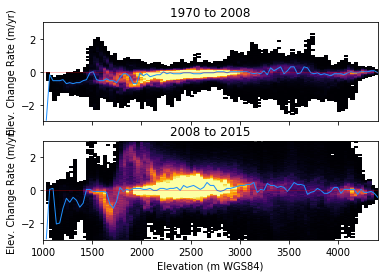

In [27]:
f, axa = plt.subplots(2, sharex=True, sharey=True)
dem_clim = (1000,4400)
dhdt_clim = (-3, 3)

plothist(axa[0], dem_list[0], dhdt_list_shpclip[0], dem_clim, dhdt_clim)
axa[0].set_title('1970 to 2008')
axa[0].set_ylabel('Elev. Change Rate (m/yr)')
axa[0].axhline(0,lw=0.5,ls='-',c='r',alpha=0.5)

plothist(axa[1], dem_list[1], dhdt_list_shpclip[1], dem_clim, dhdt_clim)
axa[1].set_title('2008 to 2015')
axa[1].set_ylabel('Elev. Change Rate (m/yr)')
axa[1].axhline(0,lw=0.5,ls='-',c='r',alpha=0.5)
axa[1].set_xlabel('Elevation (m WGS84)')
plt.show()